In [2]:
from keras.datasets import cifar10
from keras.models import model_from_json
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD

import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K

Using TensorFlow backend.


In [3]:
eps = 0.009
model_name = '200'
num_classes = 10
label =['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
def load_model(model_name):
    model = model_from_json(open(f'models/{model_name}_model.json').read())
    model.load_weights(f'weights/{model_name}_weights.h5')

    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])

    return model

In [5]:
def predict(x, model_name):
    model = load_model(model_name)
    pred = model.predict(np.array([x]), batch_size=1)
    pred_class = np.argmax(pred)
    pred_per = round(max(pred[0]), 3)
    K.clear_session()
    
    return pred_class, pred_per

In [6]:
def generate_grads(x, label, model_name):
    
    model = load_model(model_name)
    
    class_output = model.output[:, int(label)]
    
    grads = K.gradients(class_output, model.input)[0]
    gradient_function = K.function([model.input], [grads])

    grads_val = gradient_function([np.array([x])])
    
    K.clear_session()
    
    return np.array(grads_val).reshape(32,32,3)

In [7]:
def generate_adv(x, label, model_name, eps):

    p = np.sign(generate_grads(x, label, model_name))
    adv = (x - eps*p).clip(min=0, max=1)

    return adv

In [8]:
def generate_t_adv(x, label, model_name, eps):

    p = np.sign(generate_grads(x, label, model_name))
    adv = (x + eps*p).clip(min=0, max=1)

    return adv

In [9]:
# データの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 正規化
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

y_train_catego = to_categorical(y_train, num_classes)
y_test_catego = to_categorical(y_test, num_classes)

In [10]:
model = load_model(model_name)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [11]:
score = model.evaluate(x_test, y_test_catego, verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 0.5936365000247955
Test accuracy : 0.8072


In [12]:
pred_classes = model.predict_classes(x_test)

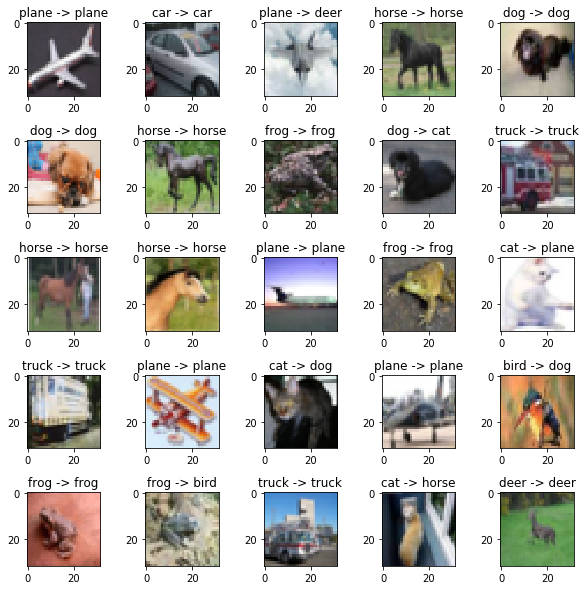

In [13]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(25):
    rand_num=np.random.randint(0,10000)
    cifar_img=plt.subplot(5,5,i+1)
    plt.imshow(x_test[rand_num])
    plt.title(f'{label[int(y_test[rand_num])]} -> {label[pred_classes[rand_num]]}')

plt.show()

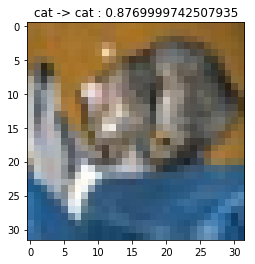

In [14]:
idx = 0
x = x_test[idx]
y = int(y_test[idx])

pred_class, pred_per = predict(x, model_name)

plt.imshow(x)
plt.title(f'{label[y]} -> {label[pred_class]} : {pred_per}')
plt.show()

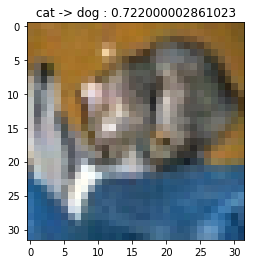

In [15]:
adv = generate_adv(x, y, model_name, eps)

pred_class, pred_per = predict(adv, model_name)

plt.imshow(adv)
plt.title(f'{label[y]} -> {label[pred_class]} : {pred_per}')
plt.show()

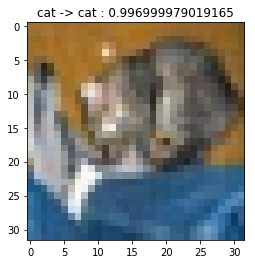

In [16]:
t_adv = generate_t_adv(x, y, model_name, eps)

pred_class, pred_per = predict(t_adv, model_name)

plt.imshow(t_adv)
plt.title(f'{label[y]} -> {label[pred_class]} : {pred_per}')
plt.show()

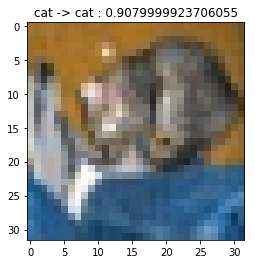

In [17]:
t_adv_adv = generate_adv(t_adv, y, model_name, eps)

pred_class, pred_per = predict(t_adv_adv, model_name)

plt.imshow(t_adv_adv)
plt.title(f'{label[y]} -> {label[pred_class]} : {pred_per}')
plt.show()

In [18]:
model = load_model(model_name)
pred_proba = model.predict_proba(x_test)

In [20]:
pred_proba.shape

(10000, 10)

In [41]:
pred_max_per = np.max(pred_proba, axis=1)
pred_max_per

0.7656985

In [24]:
np.argmax(pred_proba, axis=1)

array([3, 8, 8, ..., 5, 4, 7])

In [35]:
small_per = np.where(pred_max_per < 0.8)[0]

In [39]:
small_per

array([   3,    4,    7, ..., 9995, 9996, 9998])

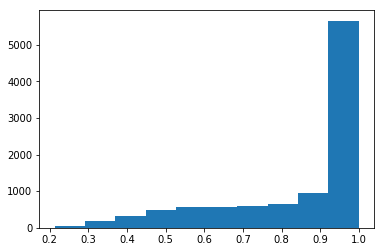

In [38]:
plt.hist(pred_max_per)
plt.show()